# Proyecto 3

## Tema 4

Vamos a realizar una tarea de clasificación ya que el objetivo de nuestra base de datos es predecir si un paciente va a tener muerte por fallo cardíaco o no.

- Explique detalladamente (no es necesario que lo implemente) qué podría hacer si no dispusiera de
partición de test y quisiera estimar la capacidad de generalización estando “suficientemente seguro”
de que las características elegidas son las más adecuadas para abordar la tarea.

Hariamos validación cruzada, dividiríamos el conjunto de entrenamiento en distintos folds (k), después entrenariamos y validariamos usando una distribucion de conjuntos diferente para todos los k folds, consiguiendo crear un conjunto de test 'artificial', que iría variando en funcion del conjunto en el que estamos. Obteniendo y analizando la media de los resultados de las figuras de mérito obtenidas en el conjunto de validación, podemos crear un modelo que permita generalizar correctamente.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, silhouette_score, silhouette_samples
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cargamos la base de datos
data = pd.read_csv('entrenamiento.csv')

data_input = data.drop(['DEATH_EVENT'], axis=1) 
data_output = data['DEATH_EVENT']

# Dividimos el conjunto en diseño y test
X_train, X_test, Y_train, Y_test = train_test_split(data_input, data_output, test_size=0.3, random_state = 13)


In [3]:
# Normalizamos el conjunto de diseño
X_res_train = X_train.copy()

scaler = MinMaxScaler()

# Todos los valores están en el rango [0,1]
data_minmax = scaler.fit_transform(X_res_train)

scaled_train = pd.DataFrame(data_minmax, columns=X_res_train.columns)
scaled_train.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,0.423623,0.488636,0.148412,0.477273,0.461591,0.443182,0.430780,0.310066,0.566177,0.625000,0.227273,0.404026
std,0.228292,0.502735,0.196812,0.502346,0.234383,0.499608,0.179432,0.193092,0.196601,0.486897,0.421472,0.303379
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.272727,0.000000,0.032389,0.000000,0.300000,0.000000,0.320988,0.200000,0.421053,0.000000,0.000000,0.103933
50%,0.409091,0.000000,0.069650,0.000000,0.460000,0.000000,0.419753,0.256000,0.578947,1.000000,0.000000,0.340824
75%,0.545455,1.000000,0.201732,1.000000,0.600000,1.000000,0.479424,0.360000,0.684211,1.000000,0.000000,0.705056
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# Normalizamos el conjunto de test

X_res_test = X_test.copy()

data_minmax = scaler.transform(X_res_test)

scaled_test = pd.DataFrame(data_minmax, columns=X_res_test.columns)
scaled_test.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,0.423923,0.421053,0.184476,0.368421,0.410526,0.473684,0.430192,0.272412,0.477839,0.657895,0.421053,0.331855
std,0.255390,0.500355,0.217344,0.488852,0.228402,0.506009,0.151331,0.176280,0.209593,0.480783,0.500355,0.251573
min,0.000000,0.000000,0.011548,0.000000,0.040000,0.000000,0.057613,0.040000,-0.105263,0.000000,0.000000,0.007491
25%,0.181818,0.000000,0.034735,0.000000,0.225000,0.000000,0.352881,0.160000,0.328947,0.000000,0.000000,0.130150
50%,0.381818,0.000000,0.119091,0.000000,0.400000,0.000000,0.445181,0.220000,0.473684,1.000000,0.000000,0.269663
75%,0.636364,1.000000,0.201732,1.000000,0.500000,1.000000,0.483539,0.293824,0.618421,1.000000,1.000000,0.452247
max,1.000000,1.000000,0.964273,1.000000,0.900000,1.000000,0.851852,0.720000,0.842105,1.000000,1.000000,0.921348


### a) Esquema K-NN
- Explique el significado del hiper-parámetro k. ¿Cómo se estima el valor del target de una determinada observación de test al aplicar el esquema k-nn?

El hiper-parámetro k indica el número de vecinos más cercano que se consideran para tomar una decisión. El valor del target se estima eligiendo la clase mayoritaria entre los k vecinos mas cercanos a una muestra dada. 
- Cómo puede encontrar el valor del hiper-parámetro k más adecuado a un conjunto de observaciones?

Mediante una búsqueda del parámetro k (probando distintos valores de k y escogiendo el valor que mejor resultados da en el modelo evaluado en el conjunto de validación) podemos encontrar el valor óptimo de k.
- Discuta razonadamente la relación entre la capacidad de generalización y el valor del
hiper-parámetro k

Un valor bajo como k = 1 hace que el algoritmo sea muy sensible al ruido ya que nuestro resultado depende unicamene de la clase perteneciente al vecino mas cercano, esto hace que el modelo se sobreajuste. Cuando k es muy grande (k cercano al número de muestras) el modelo puede subajustarse debido a que estaríamos cogiendo todas las observaciones del conjunto de muestras.
- Suponga que se ha utilizado un esquema k−nn con una base de datos en la que no ha
normalizado las características. Indique si las prestaciones obtenidas cambiarían si el
diseño y la evaluación de prestaciones se realizara con las variables normalizadas.
Justifique su respuesta.

Si cambiaría, ya que el esquema knn depende de la distancia de un punto al resto, por lo que si tenemos variables sin normalizar, y estas tienen rangos dinámicos muy distintos, el modelo no entrenará de forma correcta. Las distancias se veran dominadas por aquellas caracteristicas con escalas mayores. Normalizando las características conseguimos que todas las características contribuyan de forma equitativa.

In [5]:
acc_results=[] # accuracy
recall_results=[] # recall
roc_results = [] # roc_auc
acc_results_cv = [] # accuracy con validacion cruzada
roc_results_cv = [] # roc con validacion cruzada
recall_results_cv = [] # recall con validacion cruzada


### Exploración del hiperparámetro k
Exploraremos distintos valores de k para las figuras de mérito recall y accuracy

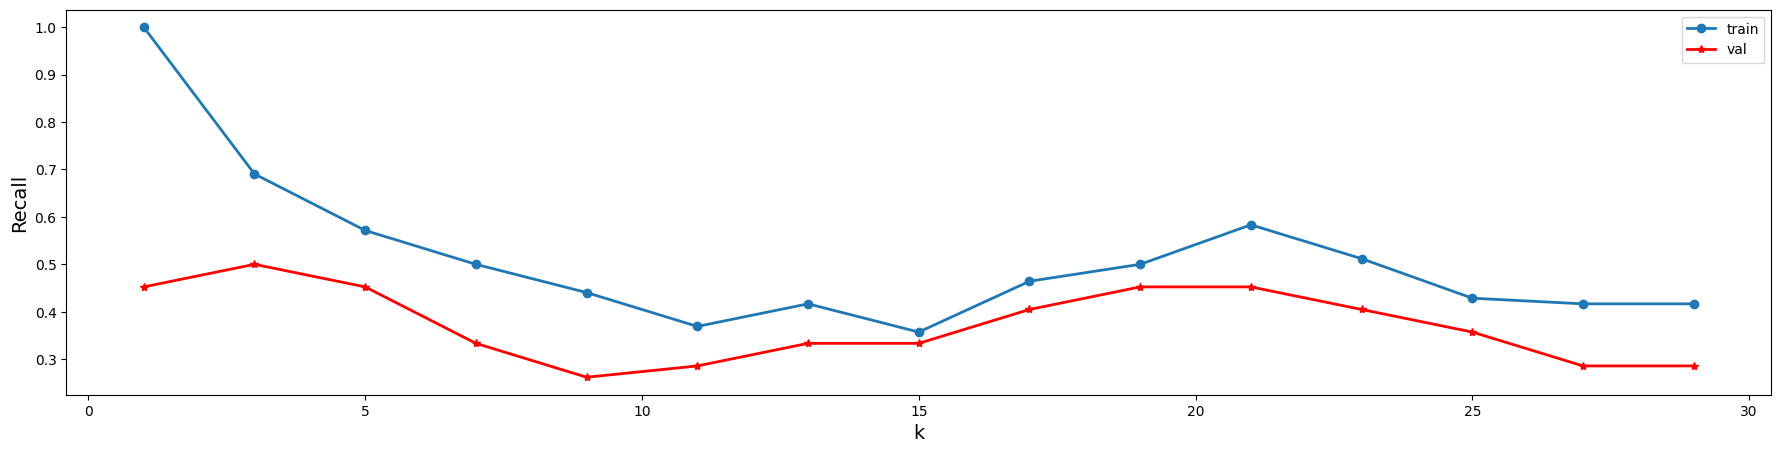

Mayor Recall en validación: 0.500
Valor correspondiente para el hiperparámetro: {'n_neighbors': 3}


In [6]:
# Selección del hiper-parámetro haciendo uso del conjunto de diseño. El criterio de elección es el recall

param_grid = {'n_neighbors': range(1,31,2)}
k_grid = np.array(range(1,31,2))

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid = param_grid, scoring = 'recall', cv=3, return_train_score=True)
grid_knn.fit(scaled_train, Y_train)
# Hemos escogido como parámetro de scoring el recall, porque en nuestra base de datos estamos intentando predecir si
# un paciente va a fallecer por un paro cardíaco o no. Por lo tanto nos interesa maximizar el número de verdaderos 
# positivos predichos sobre el resto de métricas.


rec_train = np.array(grid_knn.cv_results_['mean_train_score'])
rec_val = np.array(grid_knn.cv_results_['mean_test_score'])


plt.figure(figsize=(22,5))
plt.plot(k_grid,rec_train,'-o',label="train", linewidth=2)
plt.plot(k_grid,rec_val,'-*b',label="val", linewidth=2, color="r")
plt.xlabel('k',fontsize=14)
plt.ylabel('Recall',fontsize=14)
plt.legend()
plt.show()

print("Mayor Recall en validación: {:.3f}".format(grid_knn.best_score_))
print("Valor correspondiente para el hiperparámetro: {}".format(grid_knn.best_params_))

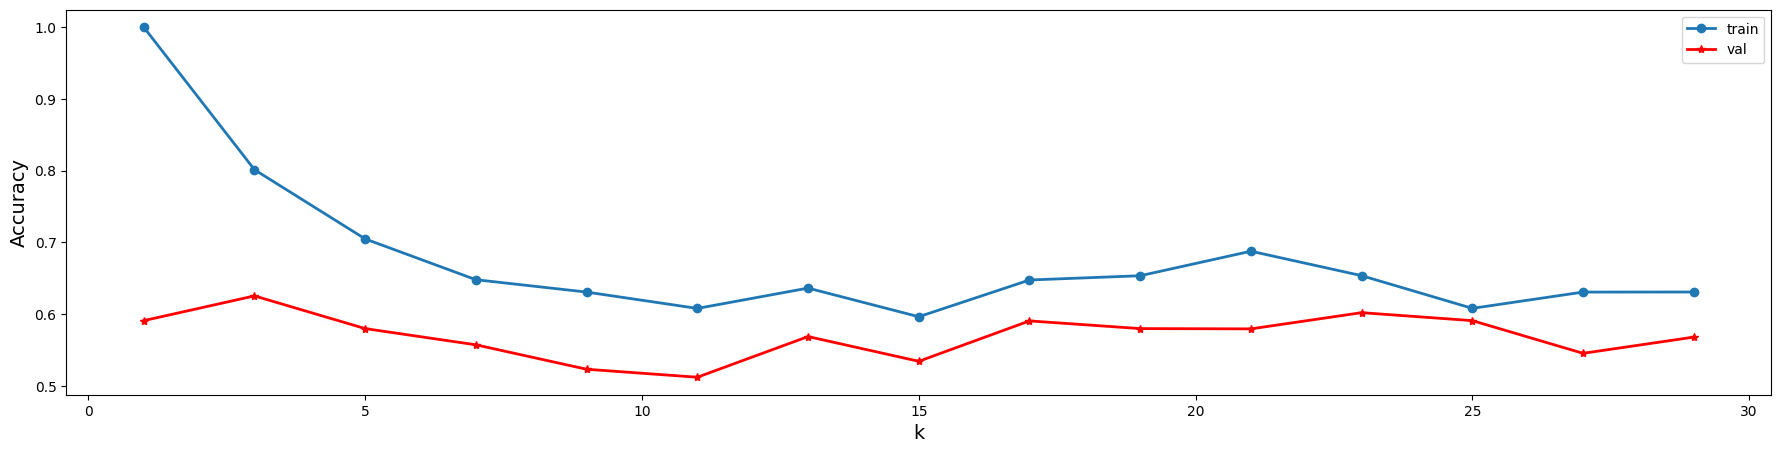

Mayor Accuracy en validación: 0.625
Valor correspondiente para el hiperparámetro: {'n_neighbors': 3}


In [35]:
# Selección del hiper-parámetro haciendo uso de accuracy

param_grid = {'n_neighbors': range(1,31,2)}
k_grid = np.array(range(1,31,2))
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid = param_grid, scoring = 'accuracy', cv=3, return_train_score=True)
grid_knn.fit(scaled_train, Y_train)


acc_train = np.array(grid_knn.cv_results_['mean_train_score'])
acc_val = np.array(grid_knn.cv_results_['mean_test_score'])


plt.figure(figsize=(22,5))
plt.plot(k_grid,acc_train,'-o',label="train", linewidth=2)
plt.plot(k_grid,acc_val,'-*b',label="val", linewidth=2, color="r")
plt.xlabel('k',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.legend()
plt.show()
print("Mayor Accuracy en validación: {:.3f}".format(grid_knn.best_score_))
print("Valor correspondiente para el hiperparámetro: {}".format(grid_knn.best_params_))

- Justifique la elección de un único valor de k.

Tanto en recall como en accuracy hemos obtenido un valor de k = 3, ya que es el valor que mejor métrica aporta en el conjunto de val.
Esto significa que el modelo puede encontrar un equilibrio entre evitar el sobreajuste (k muy pequeña) y el subajuste (k muy grande). 
Los valores de las métricas no son muy buenos, porque no hay suficientes datos para entrenar el modelo de una forma eficiente y robusta.

### Determinamos figuras de mérito
En nuestro caso vamos a calcular la accuracy, el recall, la precisión y la curva roc

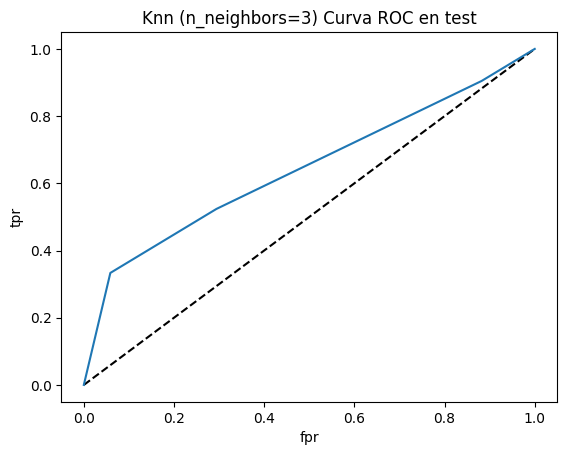

Accuracy: 0.6052631578947368
Recall: 0.5238095238095238
Precisión: 0.6875
Roc: 0.6428571428571428


In [8]:
# Creamos el modelo con nuestro valor de k
knn = KNeighborsClassifier(n_neighbors = 3)

#Entrenamos el modelo
knn.fit(scaled_train, Y_train)

# Obtenemos la predicción
y_pred = knn.predict(scaled_test) 

# Calculamos el accuracy 
accuracy = accuracy_score(Y_test, y_pred)
acc_results.append(accuracy)
# Validación
acc_cv = cross_val_score(knn, np.array(scaled_train), Y_train, scoring='accuracy', cv=3)
acc_results_cv.append(np.mean(acc_cv))

# Calculamos el recall
recall = recall_score(Y_test, y_pred)
recall_results.append(recall)
# Validación
recall_cv = cross_val_score(knn, np.array(scaled_train), Y_train, scoring='recall', cv=3)
recall_results_cv.append(np.mean(recall_cv))

# Calculamos la precision
precision = precision_score(Y_test, y_pred)

# Calculamos el roc_auc
y_probs = knn.predict_proba(scaled_test)[:, 1]
roc_auc = roc_auc_score(Y_test, y_probs)
roc_results.append(roc_auc)
# Usamos probabilidades porque estamos trabajando un problema de clasificación binaria, y para calcular la roc_auc 
# es necesario calcularlas
# Validación
roc_cv = cross_val_score(knn, np.array(scaled_train), Y_train, scoring='roc_auc', cv=3)
roc_results_cv.append(np.mean(roc_cv))

# Representamos la curva ROC
fpr, tpr, thresholds = roc_curve(Y_test, y_probs)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn (n_neighbors=3) Curva ROC en test')
plt.show()

print(f'Accuracy: {accuracy}\nRecall: {recall}\nPrecisión: {precision}\nRoc: {roc_auc}')

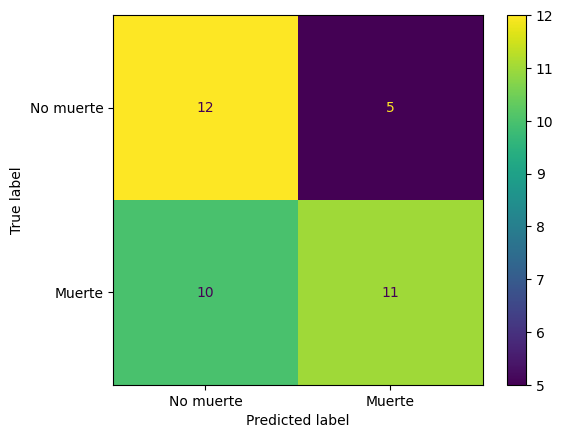

In [9]:
# Representamos la matriz de confusión
ConfusionMatrixDisplay(confusion_matrix(Y_test, y_pred), display_labels=["No muerte", "Muerte"]).plot()

#### Conclusión

Aunque los valores de las métricas obtenidos no son muy buenos, coinciden con los valores obtenidos para el conjunto de validación en test, por lo tanto, podemos comprobar que el algoritmo es consistente con los resultados. En conclusión, creemos que knn no es el mejor método de predicción para nuestro caso.

## Árboles

- Justifique razonadamente la conveniencia o no de normalizar las características antes de
aplicar este esquema de aprendizaje.

La normalización no suele ser necesaria, ya que los arboles realizan decisiónes en base a umbrales y estas decisiones son invariantes a un cambio de escala. El único cambio que habría sería la escala de los umbrales, lo que podría dificultar la interpretación de arbol al no tener la escala original.

### Evaluación con distintos valores del hiperparámetro 'mínimo número de muestras por nodo'

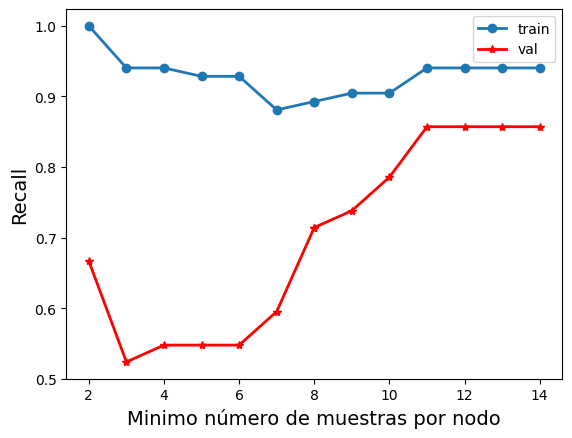

Mejor recall en validación cruzada: 0.857
Mejor valor del hiperparámetro (mínimo número de muestras por nodo): {'min_samples_split': 11}


In [38]:
# 1. Selección de hiper-parámetros del árbol. En principio, consideraremos sólo el mínimo numero de muestras
# Para saber los valores del hiperparámetro que vamos a explorar, nos vamos a basar en los porcentajes de observaciones
# que tiene nuestro conjunto de datos.
percentages = np.linspace(0.01, 0.15, 15) # Exploramos los porcentajes de 1 al 15 en pasos de 0.01
min_samples_split_values = []

for p in percentages:
    valor = int(np.ceil(p *len(X_train))) # Calculamos el valor que corresponde al porcentaje
    min_samples_split_values.append(valor)
    
param_grid = {'min_samples_split': min_samples_split_values}

grid_arbol_clasif = GridSearchCV(DecisionTreeClassifier(random_state=13), param_grid = param_grid, scoring = 'recall', cv=3, return_train_score=True)
grid_arbol_clasif.fit(X_train, Y_train)

mse_train_arbol = np.array(grid_arbol_clasif.cv_results_['mean_train_score'])
mse_val_arbol = np.array(grid_arbol_clasif.cv_results_['mean_test_score'])

plt.plot(min_samples_split_values,mse_train_arbol,'-o',label="train", linewidth=2)
plt.plot(min_samples_split_values,mse_val_arbol,'-*b',label="val", linewidth=2, color ="r")

plt.xlabel('Minimo número de muestras por nodo',fontsize=14)
plt.ylabel('Recall',fontsize=14)
plt.legend()
plt.show()

print("Mejor recall en validación cruzada: {:.3f}".format(grid_arbol_clasif.best_score_)) 
print("Mejor valor del hiperparámetro (mínimo número de muestras por nodo): {}".format(grid_arbol_clasif.best_params_))

Elegimos el valor 10 u 11 como hiperparámetro porque nos proporciona el mejor valor de recall. Para saber si la decisión es acertada, vamos a explorar otras figuras de mérito.


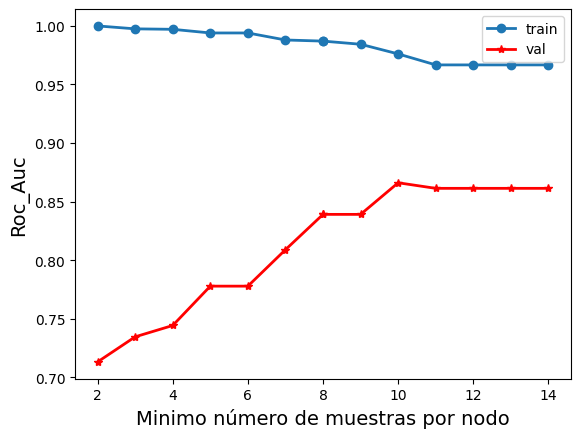

Mejor Roc_Auc en val: 0.866
Mejor valor del hiperparámetro: {'min_samples_split': 10}


In [39]:
# Evaluamos con roc_auc
percentages = np.linspace(0.01, 0.15, 15)
min_samples_split_values = []

for p in percentages:
    valor = int(np.ceil(p *len(X_train))) # Calculamos el valor que corrsponde al porcentaje
    min_samples_split_values.append(valor)
    
param_grid = {'min_samples_split': min_samples_split_values}

grid_arbol_clasif = GridSearchCV(DecisionTreeClassifier(random_state=13), param_grid = param_grid, scoring = 'roc_auc', cv=3, return_train_score=True)
grid_arbol_clasif.fit(X_train, Y_train)

mse_train_arbol = np.array(grid_arbol_clasif.cv_results_['mean_train_score'])
mse_val_arbol = np.array(grid_arbol_clasif.cv_results_['mean_test_score'])

plt.plot(min_samples_split_values,mse_train_arbol,'-o',label="train", linewidth=2)
plt.plot(min_samples_split_values,mse_val_arbol,'-*b',label="val", linewidth=2, color ="r")

plt.xlabel('Minimo número de muestras por nodo',fontsize=14)
plt.ylabel('Roc_Auc',fontsize=14)
plt.legend()
plt.show()

print("Mejor Roc_Auc en validación cruzada: {:.3f}".format(grid_arbol_clasif.best_score_)) 
print("Mejor valor del hiperparámetro (número de muestras): {}".format(grid_arbol_clasif.best_params_))

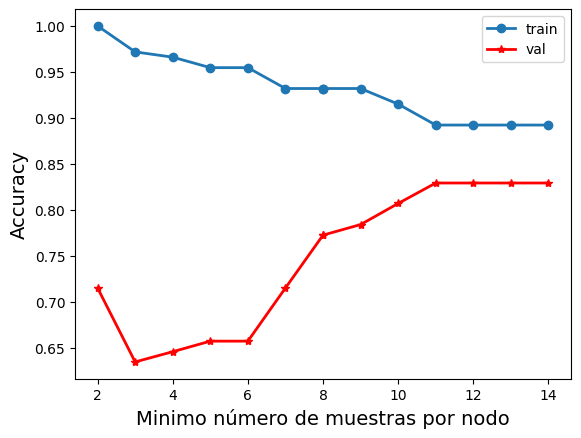

Mejor accuracy en val: 0.829
Mejor valor del hiperparámetro: {'min_samples_split': 11}


In [40]:
# Evaluamos con accuracy
percentages = np.linspace(0.01, 0.15, 15) 
min_samples_split_values = []

for p in percentages:
    valor = int(np.ceil(p *len(X_train))) # Calculamos el valor que corrsponde al porcentaje
    min_samples_split_values.append(valor)
    
param_grid = {'min_samples_split': min_samples_split_values}

grid_arbol_clasif = GridSearchCV(DecisionTreeClassifier(random_state=13), param_grid = param_grid, scoring = 'accuracy', cv=3, return_train_score=True)
grid_arbol_clasif.fit(X_train, Y_train)

mse_train_arbol = np.array(grid_arbol_clasif.cv_results_['mean_train_score'])
mse_val_arbol = np.array(grid_arbol_clasif.cv_results_['mean_test_score'])

plt.plot(min_samples_split_values,mse_train_arbol,'-o',label="train", linewidth=2)
plt.plot(min_samples_split_values,mse_val_arbol,'-*b',label="val", linewidth=2, color ="r")

plt.xlabel('Minimo número de muestras por nodo',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.legend()
plt.show()

print("Mejor accuracy en val: {:.3f}".format(grid_arbol_clasif.best_score_)) 
print("Mejor valor del hiperparámetro: {}".format(grid_arbol_clasif.best_params_))#nos sale el 12% y nos parece mucho

Como podemos observar en la gráfica, el mejor valor de las métricas en validación siempre aparece cuando el mínimo valor de muestras por hoja es 10 u 11

### Visualizar el árbol

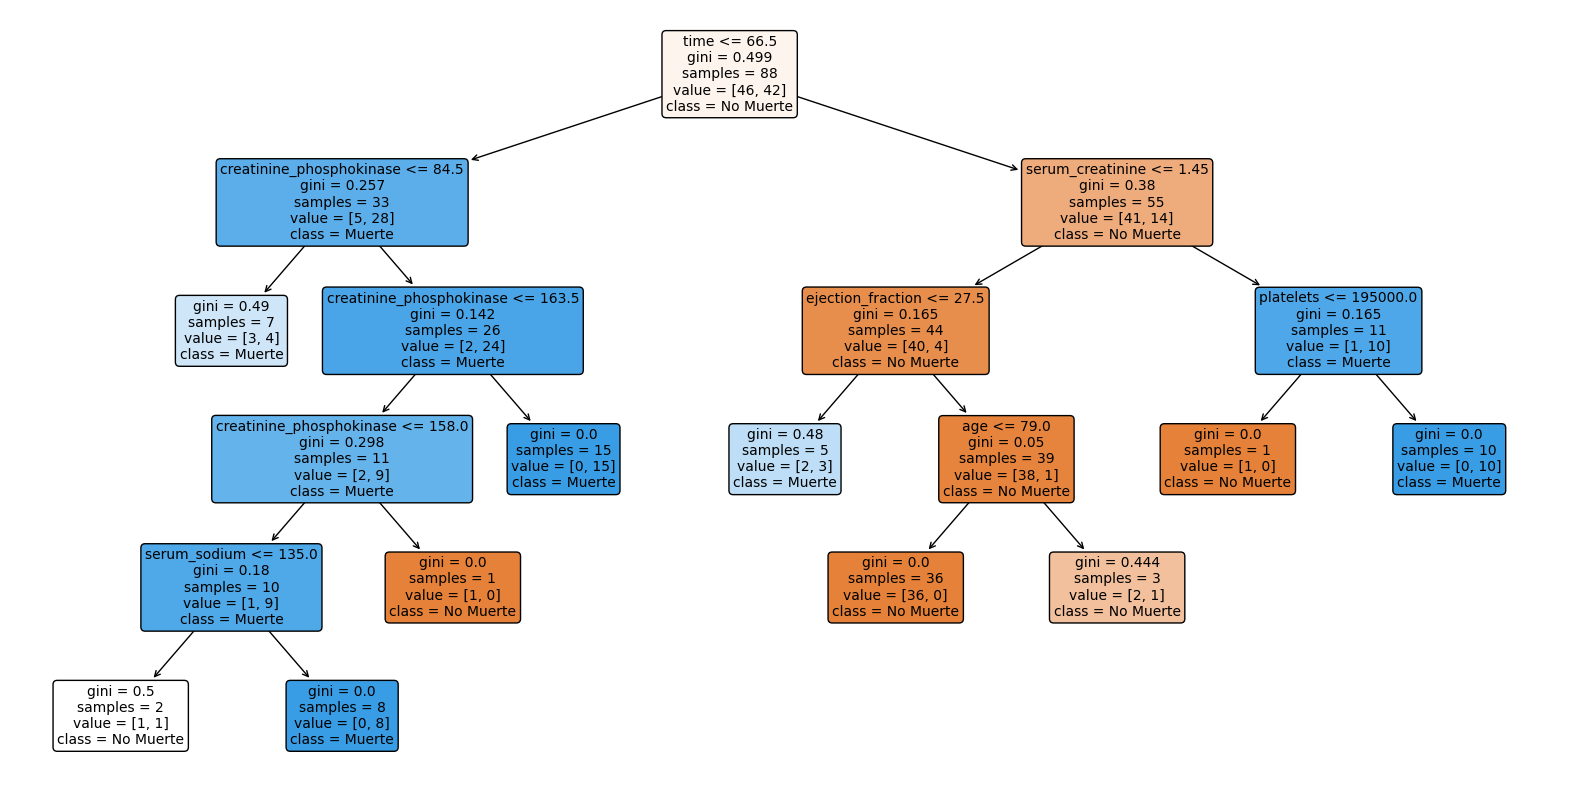

age: 0.017
anaemia: 0.000
creatinine_phosphokinase: 0.091
diabetes: 0.000
ejection_fraction: 0.082
high_blood_pressure: 0.000
platelets: 0.051
serum_creatinine: 0.330
serum_sodium: 0.022
sex: 0.000
smoking: 0.000
time: 0.407


In [13]:
# Crear el árbol de decisión con el hiperparámetro
arbol_clasificacion = DecisionTreeClassifier(min_samples_split=10, random_state=13)

# Entrenar el árbol con los datos de entrenamiento
arbol_clasificacion.fit(X_train, Y_train)

# Ahora puedes usar arbol_clasificacion para hacer predicciones, evaluar el modelo, etc.
y_pred = arbol_clasificacion.predict(X_test)

plt.figure(figsize=(20,10))  # Ajusta el tamaño según tus necesidades
plot_tree(arbol_clasificacion, 
          filled=True,
          rounded=True,
          class_names=["No Muerte", "Muerte"],  # Cambia según tus clases
          feature_names=X_train.columns,
          fontsize = 10)
plt.show()

# Porcentaje de importancia de cada variable
importancias = arbol_clasificacion.feature_importances_
nombres_caracteristicas = X_train.columns

for nombre, importancia in zip(nombres_caracteristicas, importancias):
    print("{}: {:.3f}".format(nombre, importancia))


En el árbol podemos observar que el nodo raíz es "Time", lo cual significa que es la variable más importante para tomar una decisión. Otras variables importantes serían "creatinine_phosphokinase" y "serum_creatinine" debido a que son nodos superiores que descienden directamente de la raíz.
También hemos podido observar que las variables "sex", "smoking", "diabetes" o "anaemia" no son tan relevantes para predecir si una persona va a fallecer, por lo que no se incluyen en el árbol de decisión.

Además, gracias al código de colores del árbol podemos saber qué variables predicen mejor la muerte o no de un paciente. El color azul intenso de la variable "creatinine_phosphokinase" nos indica que es una buena variable predictora de la muerte de un paciente, mientras que el color naranja indica que la variable "serum_creatinine" predice bien la no muerte.

También nos hemos fijado en que no sería necesario dividir la variable "age", ya que todos los pacientes mueren en esa categoría.
Por último, podemos concluir que si un paciente tiene la variable "serum_sodium" más alta que 135.0, el paciente fallecerá.



### Usar 4 figuras de mérito para estimar las prestaciones sobre un conjunto de test 
Calculamos la accuracy, el recall, la precisión y la curva roc_auc

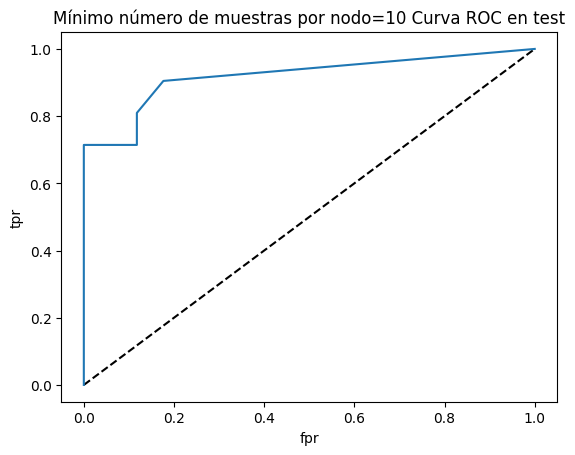

Accuracy: 0.8421052631578947
Recall: 0.8095238095238095
Precisión: 0.8947368421052632
Roc: 0.918767507002801


In [14]:
# Calculamos el accuracy 
accuracy = accuracy_score(Y_test, y_pred)
acc_results.append(accuracy)
# Validación
acc_cv = cross_val_score(arbol_clasificacion, np.array(X_train), Y_train, scoring='accuracy', cv=3)
acc_results_cv.append(np.mean(acc_cv))

# Calculamos el recall
recall = recall_score(Y_test, y_pred)
recall_results.append(recall)
# Validación
recall_cv = cross_val_score(arbol_clasificacion, np.array(X_train), Y_train, scoring='recall', cv=3)
recall_results_cv.append(np.mean(recall_cv))

# Calculamos la precision
precision = precision_score(Y_test, y_pred)

# Calculamos el roc_auc
y_probs = arbol_clasificacion.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(Y_test, y_probs)
roc_results.append(roc_auc)
# Validación
roc_cv = cross_val_score(arbol_clasificacion, np.array(X_train), Y_train, scoring='roc_auc', cv=3)
roc_results_cv.append(np.mean(roc_cv))

# Representamos la curva ROC
fpr, tpr, thresholds = roc_curve(Y_test, y_probs)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Arbol')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Mínimo número de muestras por nodo=10 Curva ROC en test')
plt.show()

print(f'Accuracy: {accuracy}\nRecall: {recall}\nPrecisión: {precision}\nRoc: {roc_auc}')

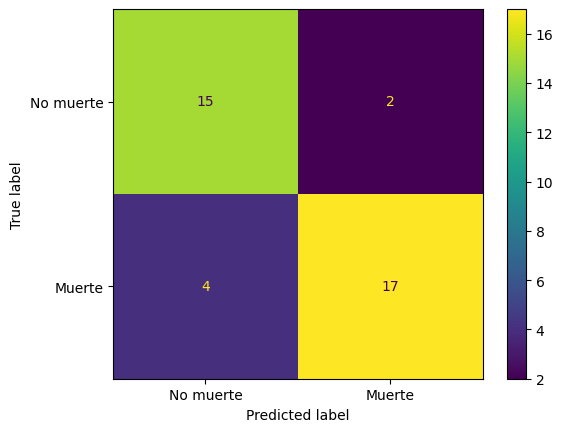

In [15]:
# Representamos la matriz de confusión
ConfusionMatrixDisplay(confusion_matrix(Y_test, y_pred), display_labels=["No muerte", "Muerte"]).plot()
plt.show()

Podemos observar que las métricas conseguidas en el conjunto de test son muy buenas, mejorando significaivamente los resultados obtenidos en knn.


### C) MLP

- En términos de subajuste y sobreajuste, justifique razonadamente cuál de ellos es más 
probable que ocurra si para resolver la tarea se considera una única capa oculta con una 
neurona. Realice el diseño correspondiente y obtenga las prestaciones del modelo 
considerando distintas figuras de mérito.

Lo más probable es que si solo hay una neurona en la capa oculta el modelo se subajuste, debido aque solo puede establecer relaciones lineales entre las características, y no puede considerar relaciones más complejas. Además, tenemos un bajo número de muestras, lo que dificulta el entrenamiento.


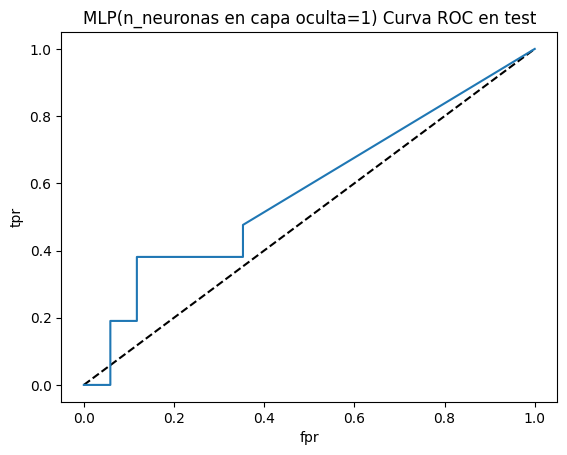

Accuracy: 0.6052631578947368
Recall: 0.38095238095238093
Precisión: 0.8
Roc: 0.5784313725490196


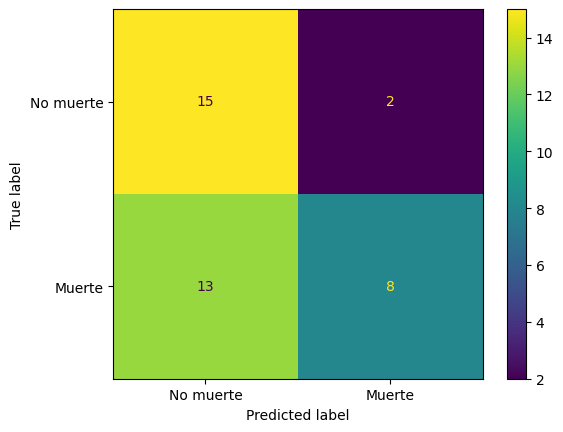

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Crear el modelo de MLP con una única neurona en la capa oculta
mlp_clasificador = MLPClassifier(hidden_layer_sizes=(1,), random_state=13)

# Entrenar el modelo con el conjunto de diseño
mlp_clasificador.fit(scaled_train, Y_train)

# Realizar predicciones en el conjunto de test
y_pred = mlp_clasificador.predict(scaled_test)

# Evaluar las prestaciones del modelo con distintas figuras de mérito
accuracy = accuracy_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)

y_pred_proba = mlp_clasificador.predict_proba(scaled_test)[:, 1]
roc_auc = roc_auc_score(Y_test, y_pred_proba)

# Representamos la curva ROC
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='MLP')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('MLP(n_neuronas en capa oculta=1) Curva ROC en test')
plt.show()

print(f'Accuracy: {accuracy}\nRecall: {recall}\nPrecisión: {precision}\nRoc: {roc_auc}')

# Representamos la matriz de confusión
ConfusionMatrixDisplay(confusion_matrix(Y_test, y_pred), display_labels=["No muerte", "Muerte"]).plot()
plt.show()

- Accuracy: el valor de accuracy no es muy alto. Debería de ser mejor especialmente porque nuestro conjunto de datos es relativamente simple.

- Recall Bajo: esto indica que el modelo no es muy bueno identificando los casos positivos reales. 

- Precisión Alta con Recall Bajo: la precisión es bastante buena, pero como el recall es bajo, esto indica que el modelo es muy conservador al hacer predicciones positivas. Tiende a predecir la clase positiva solo cuando está muy seguro, lo que resulta en un número alto de falsos negativos.

- ROC AUC Bajo: el valor de ROC AUC debería estar significativamente más cerca de 1 para considerarse un buen clasificador.

Por lo tanto, podemos concluir que el modelo está subajustado.


- Explique si considera razonable abordar el diseño de un MLP con una única capa oculta de neuronas. Explique, aplicado a su conjunto de observaciones, a qué hace referencia la afirmación “El MLP es un aproximador universal”.

Como nuestro conjunto de datos es bastante limitado, podemos considerar que una sola capa oculta es suficiente para poder predecir correctamente la salida. Esto hace que el modelo sea más simple y tenga menor riesgo de sobreajuste ya que tiene menos parámetros.
La afirmación de que "El MLP es un aproximador universal" se refiere al teorema de aproximación universal, que dice que una red neuronal con una sola capa oculta suficientemente grande puede aproximar con un error suficientemente bajo cualquier función continua, asumiendo que la función de activación de las neuronas es no lineal y no constante. En nuestro caso, creemos que sería posible modelar el problema con una sola capa oculta suficientemente grande, ya que tenemos pocas observaciones.


- Discuta la necesidad o no de normalizar las características antes de realizar el
entrenamiento del modelo

Si utilizamos los valores sin normalizar, en caso de que tengamos caracteristicas con rangos dinámicos muy diferentes, va a influir mucho más la caracteristica con mayor rango dinámico que la que tiene un menor rango a la hora de pasar por la función de activación, por lo que será muy fácil saturar dicha función y obtener salidas que no son correctas.

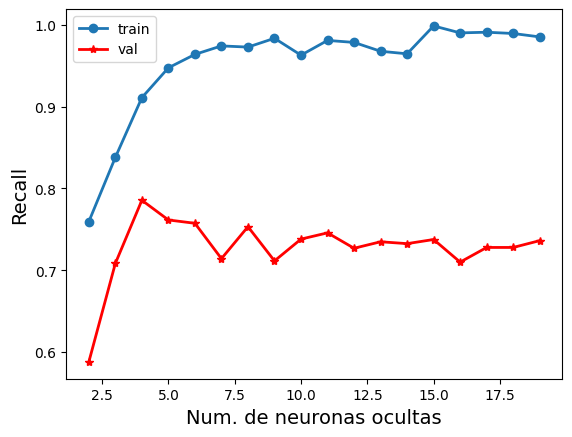

Mayor recall en validación: 0.786
Mejor valor del hiperparámetro: {'hidden_layer_sizes': 4}


In [17]:
# Gridsearch de neuronas con recall y metodo batch
param_grid = {'hidden_layer_sizes': range(2,20,1)}
neuronas_ocultas_grid = np.array(range(2,20,1)) # sólo para la representación gráfica
grid_MLP_1 = GridSearchCV(MLPClassifier(random_state=13, max_iter = 1000, batch_size = 'auto', activation='tanh'), param_grid = param_grid, scoring = 'roc_auc', cv=3, return_train_score=True )
grid_MLP_1.fit(scaled_train, Y_train)

rec_MLP_train_1 = np.array(grid_MLP_1.cv_results_['mean_train_score'])
rec_MLP_val_1 = np.array(grid_MLP_1.cv_results_['mean_test_score'])

plt.plot(neuronas_ocultas_grid,rec_MLP_train_1,'-o',label="train", linewidth=2)
plt.plot(neuronas_ocultas_grid,rec_MLP_val_1,'-*b',label="val", linewidth=2, color ="r")
plt.xlabel('Num. de neuronas ocultas',fontsize=14)
plt.ylabel('Recall',fontsize=14)
plt.legend()
plt.show()

print("Mayor recall en validación: {:.3f}".format(grid_MLP_1.best_score_))
print("Mejor valor del hiperparámetro: {}".format(grid_MLP_1.best_params_))

y_pred = grid_MLP_1.predict(scaled_test) 

Hemos elegido la arquitectura de entrenamiento con un número de neuronas ocultas de n = 4 (modelo más simple) porque nos proporciona un mejor valor de recall.

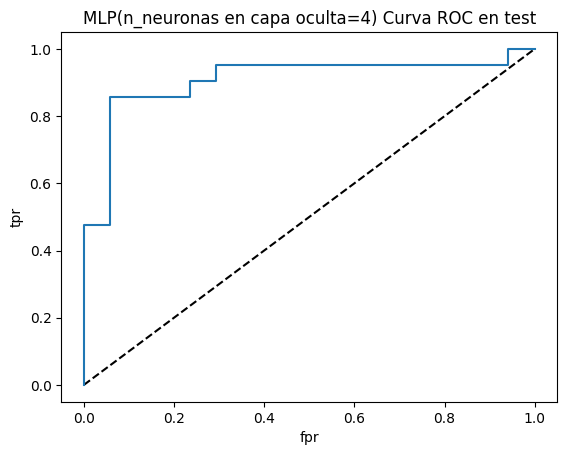

Accuracy: 0.8421052631578947
Recall: 0.9047619047619048
Precisión: 0.8260869565217391
Roc: 0.9075630252100839


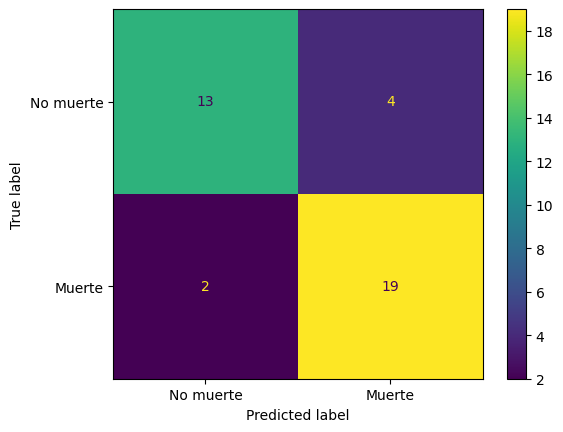

In [18]:
# Realizamos la evaluación en el conjunto de test con metodo batch

mlp_clasif = MLPClassifier(hidden_layer_sizes = (4,), activation = 'tanh', random_state = 13, max_iter = 1000, batch_size = 'auto')
mlp_clasif.fit(scaled_train, Y_train)

y_pred = mlp_clasif.predict(scaled_test)

# Calculamos el accuracy 
accuracy = accuracy_score(Y_test, y_pred)
acc_results.append(accuracy)
# Validación
acc_cv = cross_val_score(mlp_clasif, np.array(scaled_train), Y_train, scoring='accuracy', cv=3)
acc_results_cv.append(np.mean(acc_cv))

# Calculamos el recall
recall = recall_score(Y_test, y_pred)
recall_results.append(recall)
# Validación
recall_cv = cross_val_score(mlp_clasif, np.array(scaled_train), Y_train, scoring='recall', cv=3)
recall_results_cv.append(np.mean(recall_cv))

# Calculamos la precision
precision = precision_score(Y_test, y_pred)

y_pred_proba = mlp_clasif.predict_proba(scaled_test)[:, 1]
roc_auc = roc_auc_score(Y_test, y_pred_proba)
roc_results.append(roc_auc)
# Validación
roc_cv = cross_val_score(mlp_clasif, np.array(scaled_train), Y_train, scoring='roc_auc', cv=3)
roc_results_cv.append(np.mean(roc_cv))

# Representamos la curva ROC
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='MLP')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('MLP(n_neuronas en capa oculta=4) Curva ROC en test')
plt.show()

print(f'Accuracy: {accuracy}\nRecall: {recall}\nPrecisión: {precision}\nRoc: {roc_auc}')

# Representamos la matriz de confusión
ConfusionMatrixDisplay(confusion_matrix(Y_test, y_pred), display_labels=["No muerte", "Muerte"]).plot()
plt.show()

Los valores de las cuatro figuras de mérito son bastante altos, por lo que podemos concluir que el modelo de MLP con 4 neuronas en su capa oculta es capaz de predecir con bastante precisión la muerte o no muerte de un paciente.
Comparando los resultados con los resultados obtenidos por el modelo de arbol de clasificación, podemos observar que las métricas son similares, pero el recall en MLP es mayor. Esto indica que el número de verdaderos positivos respecto al número total de positivos es mayor, lo que es crucial para detectar si un paciente va a sufrir o no una muerte por fallo cardíaco, por lo tanto creemos que el mejor modelo es el MLP.

### D) Selección de características


##### Método de filtro: Mutual Info
La MI es una medida de la información que una carácteristica proporciona sobre la otra. Es útil cuando las relaciones entre las variables no son solo lineales. Calculamos la información mutua de cada caráteristica con respecto a la variable objetivo (DEATH EVENT). Las carácteristicas con mayor MI se consideran más relevantes.

Text(0.5, 1.0, 'Ordenamiento de características con criterio de Información Mútua considerando scaled train')

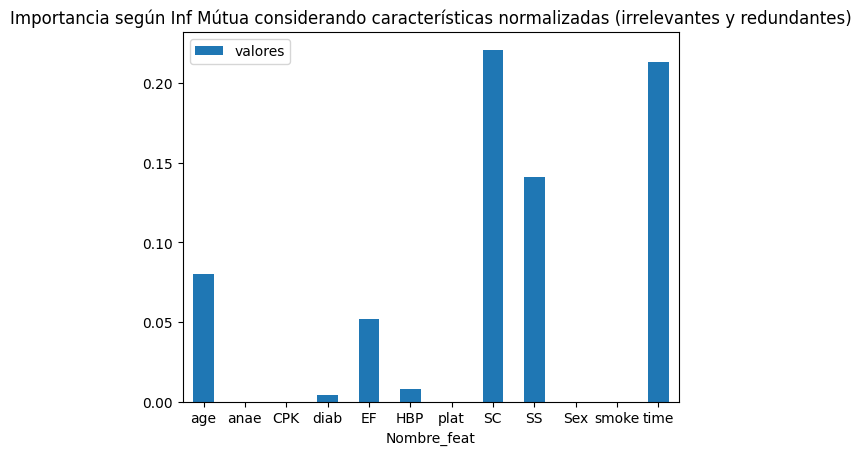

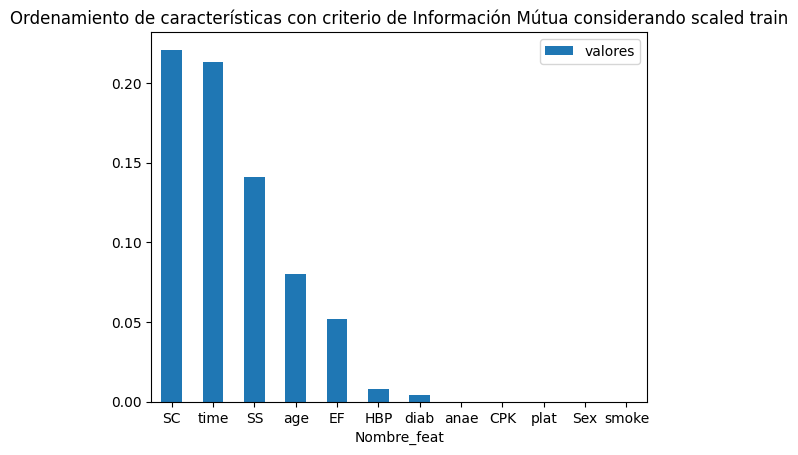

In [19]:
from sklearn.feature_selection import SelectKBest,mutual_info_classif

# Seleccionamos todas las características con el criterio de Información Mútua
bestfeatures_norm_MI = SelectKBest(score_func=mutual_info_classif, k='all')
fit_MI_norm = bestfeatures_norm_MI.fit(scaled_train, Y_train)

# Nombres de las variables
names = ["age", "anae", "CPK", "diab", "EF", "HBP", "plat", "SC", "SS", "Sex", "smoke", "time"]

df = pd.DataFrame({'Nombre_feat':names, 'valores':fit_MI_norm.scores_})
ax = df.plot.bar(x='Nombre_feat', y='valores', rot=0)
plt.title("Importancia según Inf Mútua considerando características normalizadas (irrelevantes y redundantes)")

# Ordenamos en sentido descendente (de mayor a menor), y lo representamos
df_ordenado = df.sort_values('valores', ascending=False)
ax = df_ordenado.plot.bar(x='Nombre_feat', y='valores', rot=0)
plt.title("Ordenamiento de características con criterio de Información Mútua considerando scaled train")

Consideramos que las características más relevantes son  "time", "serum_creatinine" y "serum_sodium"

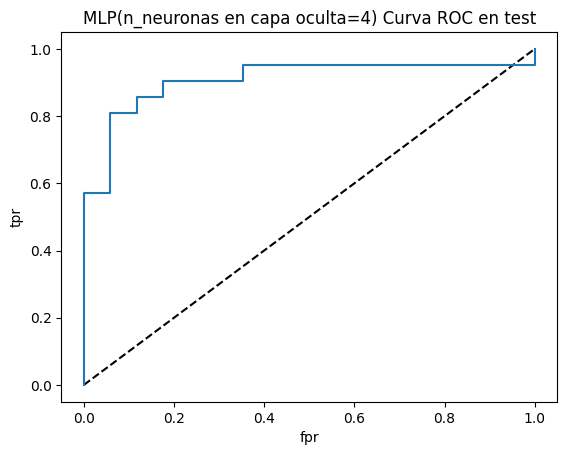

Accuracy: 0.8421052631578947
Recall: 0.8095238095238095
Precisión: 0.8947368421052632
Roc: 0.9075630252100839


In [20]:
# Evaluamos un método con las carácteristicas más relevantes según el método filter

MLP_sel = MLPClassifier(hidden_layer_sizes = (4,), activation = 'tanh', random_state = 13, max_iter = 1000, batch_size = 'auto')
MLP_sel.fit(scaled_train[['time', 'serum_creatinine', 'serum_sodium', 'ejection_fraction']], Y_train)

y_pred = MLP_sel.predict(scaled_test[['time', 'serum_creatinine', 'serum_sodium', 'ejection_fraction']])

# Calculamos el accuracy 
accuracy = accuracy_score(Y_test, y_pred)

# Calculamos el recall
recall = recall_score(Y_test, y_pred)

# Calculamos la precision
precision = precision_score(Y_test, y_pred)

y_pred_proba = MLP_sel.predict_proba(scaled_test[['time', 'serum_creatinine', 'serum_sodium', 'ejection_fraction']])[:, 1]
roc_auc = roc_auc_score(Y_test, y_pred_proba)

# Representamos la curva ROC
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='MLP')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('MLP(n_neuronas en capa oculta=4) Curva ROC en test')
plt.show()

print(f'Accuracy: {accuracy}\nRecall: {recall}\nPrecisión: {precision}\nRoc: {roc_auc}')

##### Métodos Wrapper: Forward Selection
El método forward selection comienza con un modelo sin características y agrega iterativamente características de una en una evaluando el modelo en cada paso. Siempre se agrega la carácteristica que mayor rendimiento aporte. Este método relaciona a las carácteristicas entre sí y elige la combinación de carácteristicas que mayor resultados aporte.

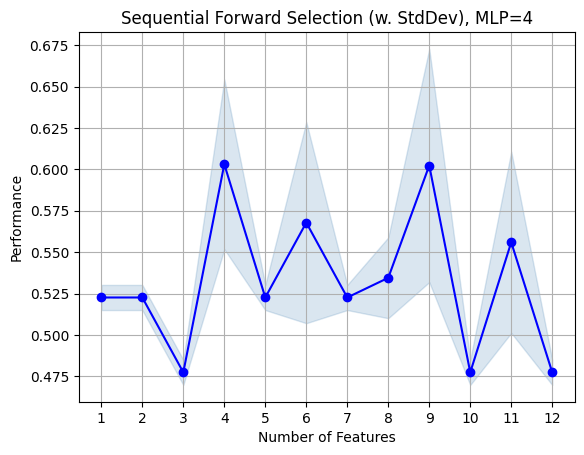

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)","[0.5333333333333333, 0.5172413793103449, 0.517...",0.522605,"(age,)",0.017071,0.007586,0.005364
2,"(0, 1)","[0.5333333333333333, 0.5172413793103449, 0.517...",0.522605,"(age, anaemia)",0.017071,0.007586,0.005364
3,"(0, 1, 4)","[0.4666666666666667, 0.4827586206896552, 0.482...",0.477395,"(age, anaemia, ejection_fraction)",0.017071,0.007586,0.005364
4,"(0, 1, 2, 4)","[0.5333333333333333, 0.6551724137931034, 0.620...",0.603065,"(age, anaemia, creatinine_phosphokinase, eject...",0.115393,0.051278,0.036259
5,"(0, 1, 2, 3, 4)","[0.5333333333333333, 0.5172413793103449, 0.517...",0.522605,"(age, anaemia, creatinine_phosphokinase, diabe...",0.017071,0.007586,0.005364
6,"(0, 1, 2, 3, 4, 11)","[0.6, 0.4827586206896552, 0.6206896551724138]",0.567816,"(age, anaemia, creatinine_phosphokinase, diabe...",0.136674,0.060735,0.042946
7,"(0, 1, 2, 3, 4, 5, 11)","[0.5333333333333333, 0.5172413793103449, 0.517...",0.522605,"(age, anaemia, creatinine_phosphokinase, diabe...",0.017071,0.007586,0.005364
8,"(0, 1, 2, 3, 4, 5, 7, 11)","[0.5, 0.5517241379310345, 0.5517241379310345]",0.534483,"(age, anaemia, creatinine_phosphokinase, diabe...",0.05487,0.024383,0.017241
9,"(0, 1, 2, 3, 4, 5, 6, 7, 11)","[0.6, 0.6896551724137931, 0.5172413793103449]",0.602299,"(age, anaemia, creatinine_phosphokinase, diabe...",0.158438,0.070406,0.049785
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 11)","[0.4666666666666667, 0.4827586206896552, 0.482...",0.477395,"(age, anaemia, creatinine_phosphokinase, diabe...",0.017071,0.007586,0.005364


In [21]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

num_neur = 4

MLP_fs = MLPClassifier(max_iter = 1000, random_state=13, activation='tanh', hidden_layer_sizes = num_neur, learning_rate = 'adaptive', early_stopping = True, batch_size='auto')
sfs_fs_4neur = SFS(MLP_fs, 
           k_features=12, 
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=3)

sfs_fs_4neur = sfs_fs_4neur.fit(scaled_train, Y_train)

# Representar los resultados
fig1 = plot_sfs(sfs_fs_4neur.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev), MLP=' + str(num_neur))
plt.grid()
plt.show()

pd.DataFrame.from_dict(sfs_fs_4neur.get_metric_dict()).T

La combinación de carácteristicas es age, anaemia, CPK y ejection fraction (4 características)

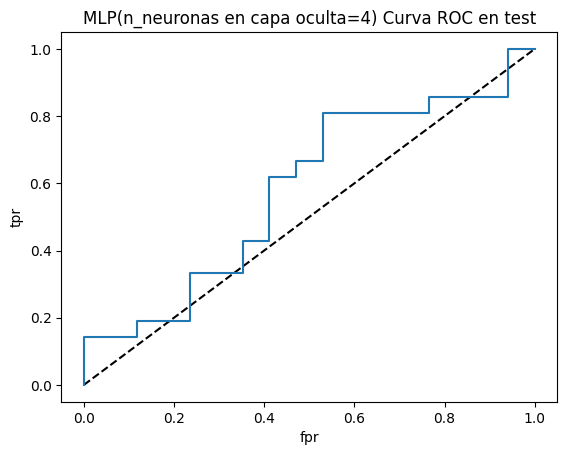

Accuracy: 0.5263157894736842
Recall: 0.47619047619047616
Precisión: 0.5882352941176471
Roc: 0.5798319327731092


In [22]:
# Evaluamos un método con las carácteristicas más relevantes según el método wrapper

MLP_sel = MLPClassifier(hidden_layer_sizes = (4,), activation = 'tanh', random_state = 13, max_iter = 1000, batch_size = 'auto')
MLP_sel.fit(scaled_train[['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction']], Y_train)

y_pred = MLP_sel.predict(scaled_test[['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction']])

# Calculamos el accuracy 
accuracy = accuracy_score(Y_test, y_pred)

# Calculamos el recall
recall = recall_score(Y_test, y_pred)

# Calculamos la precision
precision = precision_score(Y_test, y_pred)

y_pred_proba = MLP_sel.predict_proba(scaled_test[['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction']])[:, 1]
roc_auc = roc_auc_score(Y_test, y_pred_proba)

# Representamos la curva ROC
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='MLP')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('MLP(n_neuronas en capa oculta=4) Curva ROC en test')
plt.show()

print(f'Accuracy: {accuracy}\nRecall: {recall}\nPrecisión: {precision}\nRoc: {roc_auc}')

##### Método embedded: arbol de clasificación
El arbol de clasificación realiza una selección de características en base a su capacidad para separar las clases, las características que se encuentran en nodos superiores son más significativas. El arbol ya ha sido evaluado anteriormente en esta práctica, por lo que no es necesario que repitamos el código. Los resultados eran los siguientes: 

- Accuracy: 0.8421052631578947
- Recall: 0.8095238095238095
- Precisión: 0.8947368421052632
- Roc: 0.918767507002801

Como ya hemos comentado, las características más significativas seleccionadas por el arbol son time, creatinine phosphokinase y serum creatinine.


##### Comparación
Viendo los resultados observados a la salida de cada método, podemos concluir que tanto el método embedded como el primer método (filter) realizan una selección correcta de las características, obteniendo métricas muy buenas, mientras que el segundo método (wrapper) realiza una selección incorrecta, obteniendo métricas deficientes. Para nuestro conjunto, consideramos una buena opción elegir entre los métodos filter o embedded debido a sus resultados muy parecidos.

### Método ensemble

- Explique intuitivamente el funcionamiento del método elegido, así como el hiperparámetro a considerar

El método random forest, construye muchos arboles de decisión independientes para el entrenamiento, cada arbol se construye a partir de una muestra diferente del conjunto de datos y elige un subconjunto aleatorio de características. Por último, se elige por votación la clase mayoritaria para cada observación.

Hemos usado como hiper-parámetros: n-estimators = 250 (nuestro bosque tendrá 250 árboles, a más árboles mayor precisión del modelo) y min_samples_split = 10 (minimo número de muestras para poder dividir un nodo, ha sido calculado en el apartado de el arbol de clasificación).

Ordenamiento de características por importancia en Random Forest:
1. Característica 11 - time (0.324490)
2. Característica 7 - SC (0.228236)
3. Característica 4 - EF (0.113058)
4. Característica 8 - SS (0.080816)
5. Característica 0 - age (0.077479)
6. Característica 2 - CPK (0.073630)
7. Característica 6 - plat (0.065089)
8. Característica 1 - anae (0.011469)
9. Característica 5 - HBP (0.007654)
10. Característica 3 - diab (0.006928)
11. Característica 10 - smoke (0.006556)
12. Característica 9 - Sex (0.004595)


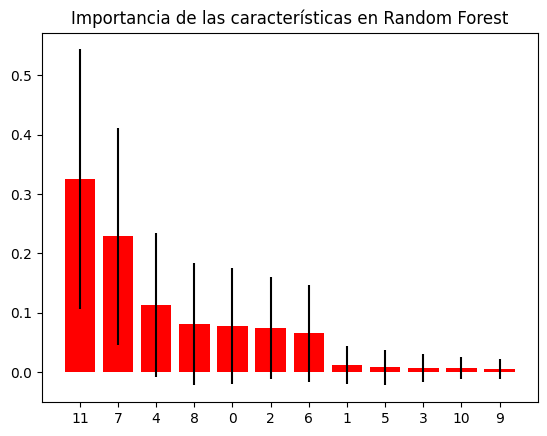

Accuracy: 0.8157894736842105
Recall: 0.8095238095238095
Precisión: 0.85
Roc: 0.9271708683473389


In [23]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

# Crear el modelo de Random Forest para clasificación
rf_classifier = RandomForestClassifier(n_estimators=250,
                                       min_samples_split=10,
                                       random_state=0,
                                       criterion='gini')

# Entrenar el modelo
rf_classifier.fit(X_train, Y_train)

# Obtener la importancia de las características
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Muestra el ordenamiento
print("Ordenamiento de características por importancia en Random Forest:")
for f in range(X_train.shape[1]):
    print("%d. Característica %d - %s (%f)" % (f + 1, indices[f], names[indices[f]], importances[indices[f]]))

# Graficar la importancia de las características del clasificador
plt.figure()
plt.title("Importancia de las características en Random Forest")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

#Usamos el clasificador ya entrenado para predecir
y_pred = rf_classifier.predict(X_test)

# Calculamos el accuracy 
accuracy = accuracy_score(Y_test, y_pred)
acc_results.append(accuracy)
# Validación
acc_cv = cross_val_score(rf_classifier, np.array(X_train), Y_train, scoring='accuracy', cv=3)
acc_results_cv.append(np.mean(acc_cv))

# Calculamos el recall
recall = recall_score(Y_test, y_pred)
recall_results.append(recall)
# Validación
recall_cv = cross_val_score(rf_classifier, np.array(X_train), Y_train, scoring='recall', cv=3)
recall_results_cv.append(np.mean(recall_cv))

# Calculamos la precision
precision = precision_score(Y_test, y_pred)

# Calculamos el roc_auc
y_probs = rf_classifier.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(Y_test, y_probs)
roc_results.append(roc_auc)
# Validación
roc_cv = cross_val_score(rf_classifier, np.array(X_train), Y_train, scoring='roc_auc', cv=3)
roc_results_cv.append(np.mean(roc_cv))

print(f'Accuracy: {accuracy}\nRecall: {recall}\nPrecisión: {precision}\nRoc: {roc_auc}')

Podemos observar que los resultados obtenidos son muy buenos sin llegar a superar los resultados de MLP

### Comparación

In [24]:
results = pd.DataFrame()

results["Accuracy en el conjunto de test"] = acc_results
results["Recall en el conjunto de test"] = recall_results
results["ROC_AUC en el conjunto de test"] = roc_results
results["Accuracy con validación cruzada"] = acc_results_cv
results["Recall con validación cruzada"] = recall_results_cv
results["ROC_AUC con validación cruzada"] = roc_results_cv

results["Models"] = ["KNN (n = 3)", "Arbol (mss = 10)", "MLP (n = 4)", "Random forest"]
results.set_index("Models", inplace = True)

results

,Accuracy en el conjunto de test,Recall en el conjunto de test,ROC_AUC en el conjunto de test,Accuracy con validación cruzada,Recall con validación cruzada,ROC_AUC con validación cruzada
Models,,,,,,
KNN (n = 3),0.605263,0.523810,0.642857,0.625287,0.500000,0.635714
Arbol (mss = 10),0.842105,0.809524,0.918768,0.806897,0.785714,0.866121
MLP (n = 4),0.842105,0.904762,0.907563,0.726820,0.642857,0.785516
Random forest,0.815789,0.809524,0.927171,0.795019,0.761905,0.868750


A la vista de los resultados, podemos afirmar que el mejor modelo es el de arbol, ya que es el que tiene mejores resultados en validación cruzada.

## Tema 5
#### Algoritmo K-means


JUSTIFICAR --> COGER MAYORES MÉTRICAS
pREPOCESAMIENTO --> NORMALIZACION


In [25]:
# Vamos a utilizar los datos normalizados, ya que en nuestro caso, hay caracteristicas con rangos dinamicos muy diferentes que pueden influir en el calculo de las 
# distancias de los centroides.

num = np.arange(2, 21, 1)

kmeans_models = {} 
centroids = {}      
inertia = {}
etiquetas = {}
samples_silhouette_values = {}
samples_avg = {}

for i in num:
    kmeans = KMeans(n_clusters=i, verbose=1, init='random').fit(scaled_train)
    kmeans_models[f'kmeans_{i}'] = kmeans
    inertia[f'inertia_{i}'] = kmeans.inertia_
    centroids[f'centroids_{i}'] = kmeans.cluster_centers_
    etiquetas[f'etiquetas_{i}'] = kmeans.labels_
    key = f'centroids_{i}'
    #print(f'Coordenadas de los centroides resultantes del algoritmo {i}-medias: {centroids[key]}')
    # Obtenemos la silueta
    key2 = f'etiquetas_{i}'
    samples_avg[f'samples_avg_{i}'] = silhouette_score(scaled_train, etiquetas[key2])
    samples_silhouette_values[f'sample_silhouette_values_{i}'] = silhouette_samples(scaled_train, etiquetas[key2])

Initialization complete
Iteration 0, inertia 211.04635323756494.
Iteration 1, inertia 110.03467621060332.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 189.28126565777188.
Iteration 1, inertia 113.75710394970054.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 227.3104988711151.
Iteration 1, inertia 111.81894370137354.
Iteration 2, inertia 109.12157342799873.
Iteration 3, inertia 108.7542330996954.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 217.19108496418886.
Iteration 1, inertia 114.25756049664466.
Iteration 2, inertia 110.73170907743646.
Iteration 3, inertia 110.06476858060024.
Iteration 4, inertia 109.83238265832416.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 192.7950765172552.
Iteration 1, inertia 114.23706029112441.
Iteration 2, inertia 113.52936508166115.
Converged at iteration 2: strict convergenc

Iteration 10, inertia 83.70140402243265.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 133.6837805365455.
Iteration 1, inertia 87.84949153860117.
Iteration 2, inertia 86.7678157679249.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 146.38412656251262.
Iteration 1, inertia 97.75959397070827.
Iteration 2, inertia 87.62007219388424.
Iteration 3, inertia 84.85605687487129.
Iteration 4, inertia 84.1391872671413.
Iteration 5, inertia 83.60967298458935.
Iteration 6, inertia 83.17840077126519.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 145.13398513604741.
Iteration 1, inertia 88.09733137518987.
Iteration 2, inertia 84.54293784183177.
Iteration 3, inertia 82.45949285358473.
Iteration 4, inertia 80.15060025115456.
Iteration 5, inertia 78.37640806085908.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 125.3425131584957

In [26]:
# Obtenemos el valor de la INERCIA  
for i in num:
    key = f'inertia_{i}'
    print(f'Valor de inercia con k={i}: {inertia[key]}')

Valor de inercia con k=2: 108.08239636101263
Valor de inercia con k=3: 92.77492446538746
Valor de inercia con k=4: 83.17840077126519
Valor de inercia con k=5: 74.93210776970972
Valor de inercia con k=6: 69.29877046010955
Valor de inercia con k=7: 64.07639902399265
Valor de inercia con k=8: 58.35282698290388
Valor de inercia con k=9: 55.056438943347345
Valor de inercia con k=10: 51.58199088737269
Valor de inercia con k=11: 48.364050380773804
Valor de inercia con k=12: 47.09855774394492
Valor de inercia con k=13: 44.283563796602586
Valor de inercia con k=14: 41.577137965060274
Valor de inercia con k=15: 41.2875732913989
Valor de inercia con k=16: 38.17775746406699
Valor de inercia con k=17: 37.64425566365649
Valor de inercia con k=18: 35.007854157309126
Valor de inercia con k=19: 34.1514774289002
Valor de inercia con k=20: 33.96054618341375


In [27]:
# Obtenemos el valor de la SILUETA  
for i in num:
    key = f'samples_avg_{i}'
    print(f'Valor de silueta con k={i}: {samples_avg[key]}')

Valor de silueta con k=2: 0.1701082095507034
Valor de silueta con k=3: 0.17568835795904011
Valor de silueta con k=4: 0.17732284606160106
Valor de silueta con k=5: 0.19154500350737502
Valor de silueta con k=6: 0.1927055343795031
Valor de silueta con k=7: 0.20770839492029253
Valor de silueta con k=8: 0.197839661918037
Valor de silueta con k=9: 0.19921578802058953
Valor de silueta con k=10: 0.2277909463477673
Valor de silueta con k=11: 0.21400283810398968
Valor de silueta con k=12: 0.2141882078993108
Valor de silueta con k=13: 0.22088280809155855
Valor de silueta con k=14: 0.22474900742987805
Valor de silueta con k=15: 0.21410228912277593
Valor de silueta con k=16: 0.22102584723875615
Valor de silueta con k=17: 0.21432124224796087
Valor de silueta con k=18: 0.226504334838107
Valor de silueta con k=19: 0.22232799062210687
Valor de silueta con k=20: 0.22402407252037604


Una vez hemos visto todos los resultados de las métricas, podemos decidir que numero de clusters es el que vamos a elegir. En nuestro caso, las figuras de mérito aumentaban progresivamente con el numero de cluster, sin embargo, consideramos que valores superiores a 7 eran demasiado grandes para la cantidad de datos que teniamos (88 muestras), por lo que decidimos quedarnos con un total de 7 clusters.

En cuanto al procesamiento, como se ha indicado antes, hemos realizado una normalización de los datos, ya que teníamos características con rangos dinámicos muy diferentes que podían influir negativamente en el resultado.

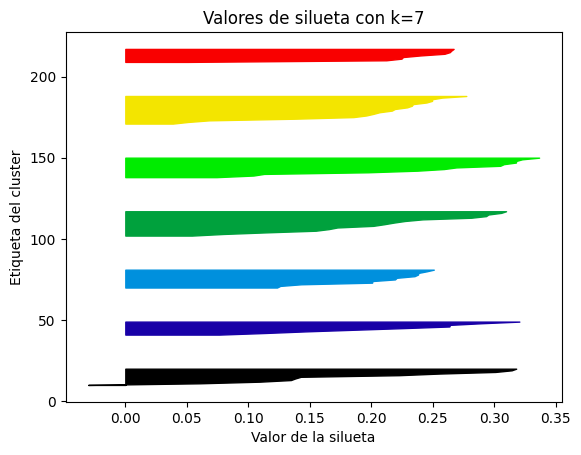

In [28]:
# Representamos esos valores
n_clusters = 7
plt.figure()

y_lower = 10
for i in range(n_clusters):
    # Consideramos los valores de silueta asociados a muestras de un único cluster
    ith_cluster_silhouette_values = \
        samples_silhouette_values['sample_silhouette_values_7'][etiquetas['etiquetas_7'] == i]

    # Ordenamos los valores de la silueta
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color) 

    # Calculamos el nuevo y_lower para la siguiente representacioón de los valores de la silueta
    y_lower = y_upper + 20  


plt.xlabel('Valor de la silueta')
plt.ylabel('Etiqueta del cluster')
plt.title('Valores de silueta con k=7')
plt.show()

#### Agrupamiento aglomerativo

A priori no tenemos forma de conocer el número ideal de cluster, podemos basarnos en la silueta calculada en el apartado anterior y de la que hemos sacado que 7 era el número de clusters ideal.

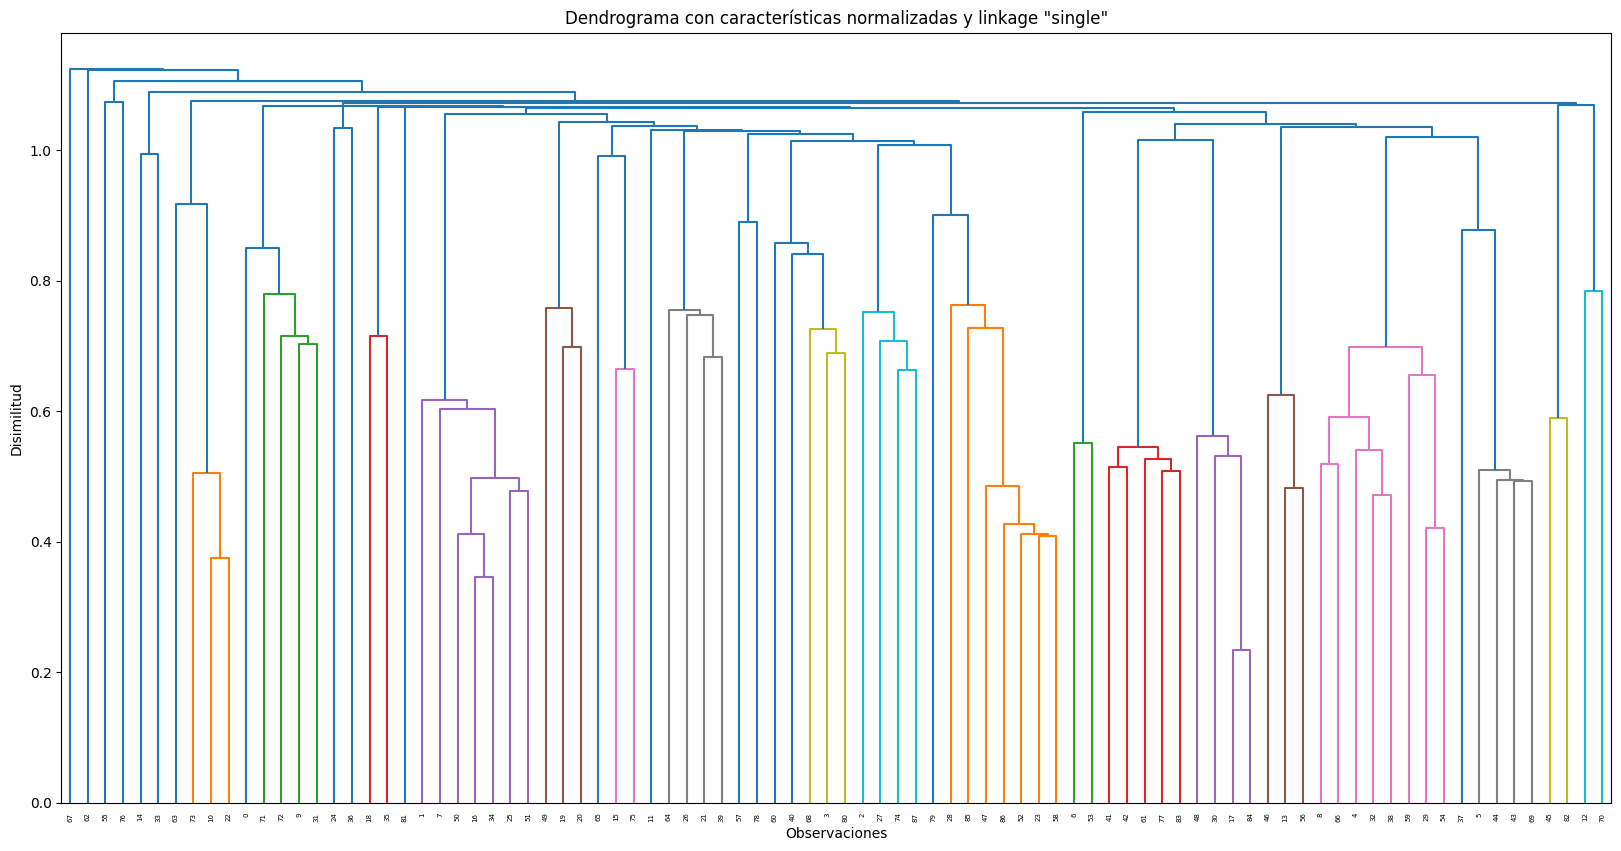

Vector con el número de observaciones de cada cluster:  [ 1  1  2  4 78  1  1]


In [29]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(20,10))

Z = sch.linkage(scaled_train, method='single', metric='euclidean')
dendrogram_single = sch.dendrogram(Z)

plt.title('Dendrograma con características normalizadas y linkage "single"')
plt.xlabel('Observaciones')
plt.ylabel('Disimilitud')
plt.show()

# Cortamos el dendrograma
clusters = sch.fcluster(Z, t=7, criterion='maxclust')

# Contamos cuántos puntos de datos hay en cada cluster
print("Vector con el número de observaciones de cada cluster: ",np.bincount(clusters - 1)) # Restamos 1 porque los clusters se numeran a partir de 1

Visualizando el dendrograma con el método single no podemos sacar mucha información sobre el número de cluster a usar, hemos realizado una separacion de las muestras en 7 clusters (usando el razonamiento que hemos empleado al principio del apartado, aunque también hemos probado con un menor numero de clusters, sin resultados) utilizando este método, y podemos observar que no estan bien distribuidas, ya que la mayoria de las muestras (casi el 90%) se encuentran en un solo cluster.

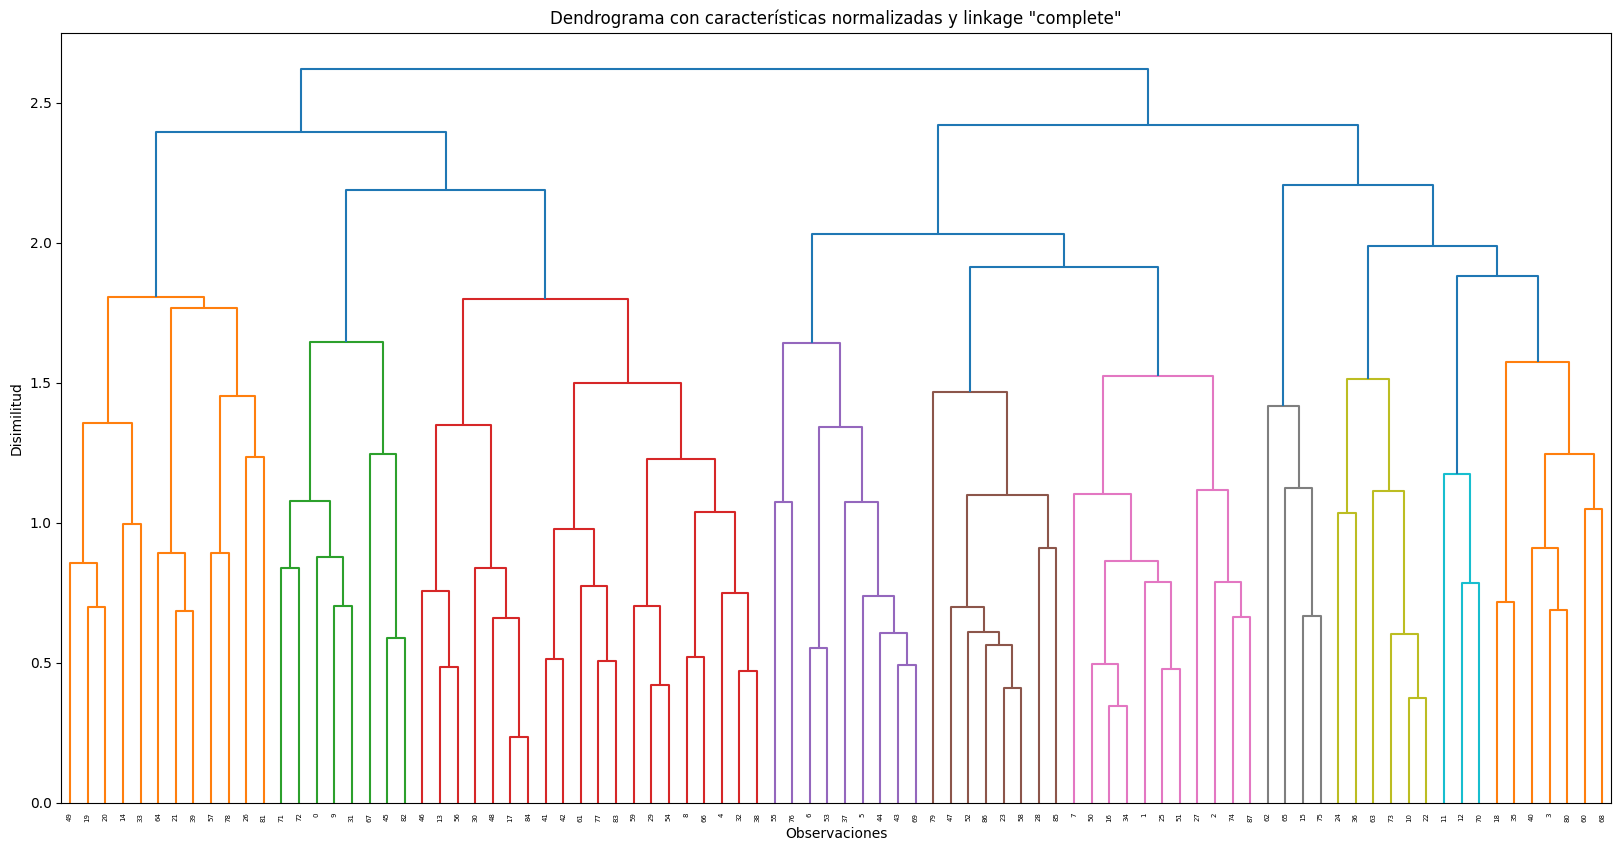

Vector con el número de observaciones de cada cluster:  [12 28 28 20]


In [30]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(20,10))

Z = sch.linkage(scaled_train, method='complete', metric='euclidean')
dendrogram_single = sch.dendrogram(Z)

plt.title('Dendrograma con características normalizadas y linkage "complete"')
plt.xlabel('Observaciones')
plt.ylabel('Disimilitud')
plt.show()

# Cortar el dendrograma para obtener dos clusters
clusters = sch.fcluster(Z, t=4, criterion='maxclust')

# Contar cuántos puntos de datos hay en cada cluster
print("Vector con el número de observaciones de cada cluster: ",np.bincount(clusters - 1))

En este caso, observando el dendrograma, podemos observar en base a las distancias que el numero ideal de clusters se encuentra entre 3 y 4 clusters, ya que más abajo en el dendrograma, las distancias entre grupos empiezan a ser cada vez menores. En este caso, fijamos el número de cluster en 4 (tambien hemos probado con otros valores pero consideramos que este es que mejor distribuye los datos) y podemos ver que las muestras se distribuyen de manera bastante más uniforme que en el caso anterior.

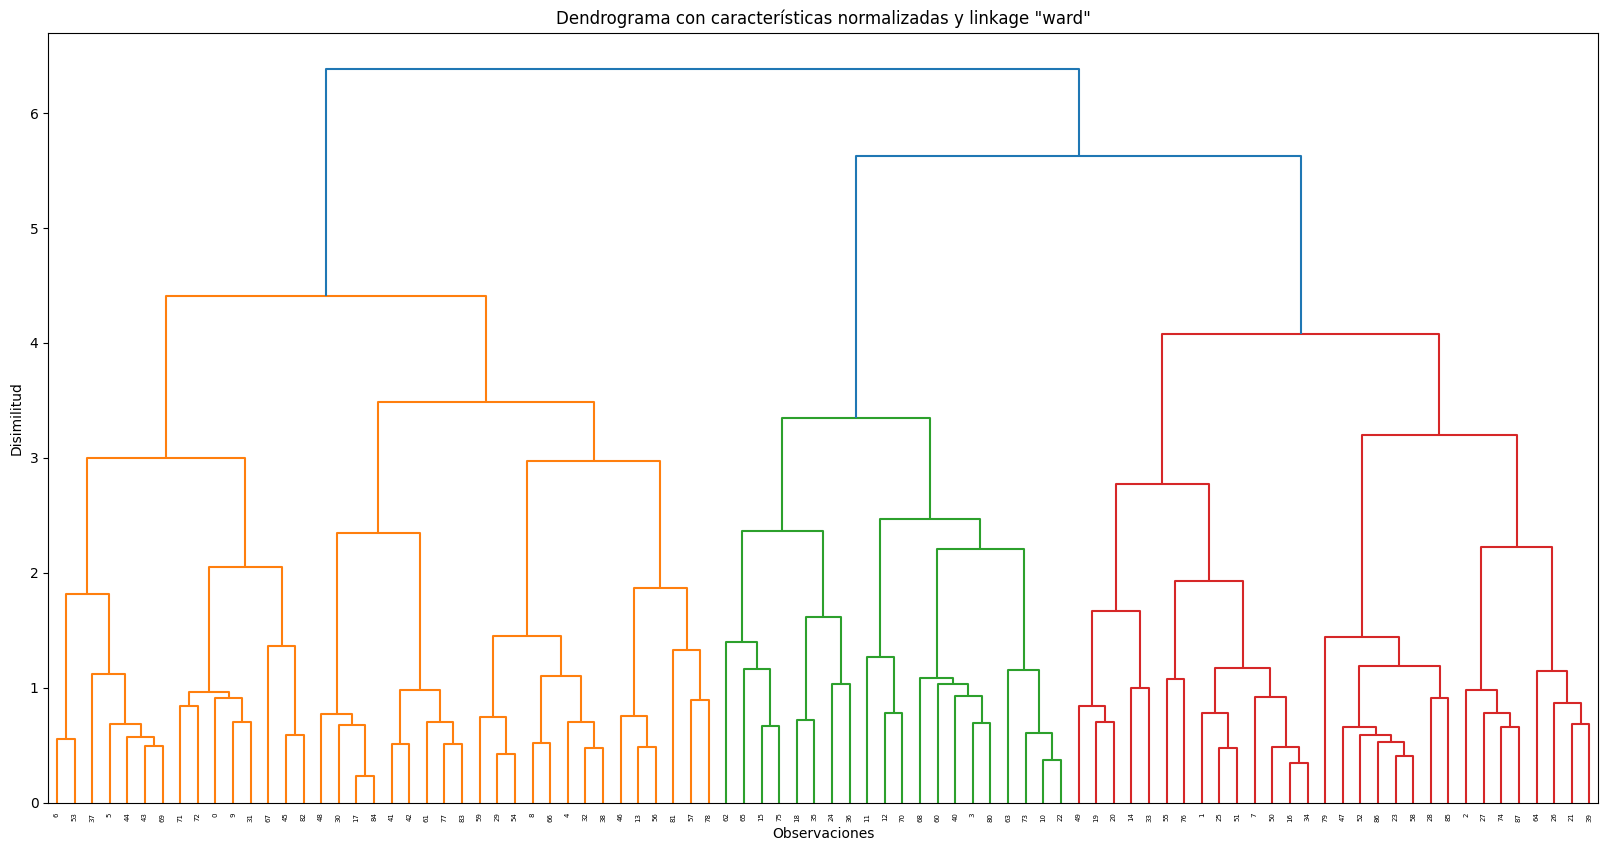

[15 23 20 30]
Cluster 1:  [ 0  5  6  9 31 37 43 44 45 53 67 69 71 72 82]
Cluster 2:  [ 4  8 13 17 29 30 32 38 41 42 46 48 54 56 57 59 61 66 77 78 81 83 84]
Cluster 3:  [ 3 10 11 12 15 18 22 24 35 36 40 60 62 63 65 68 70 73 75 80]
Cluster 4:  [ 1  2  7 14 16 19 20 21 23 25 26 27 28 33 34 39 47 49 50 51 52 55 58 64
 74 76 79 85 86 87]


In [31]:
plt.figure(figsize=(20,10))

Z = sch.linkage(scaled_train, method='ward', metric='euclidean')
dendrogram_single = sch.dendrogram(Z)

plt.title('Dendrograma con características normalizadas y linkage "ward"')
plt.xlabel('Observaciones')
plt.ylabel('Disimilitud')
plt.show()

# Cortar el dendrograma para obtener dos clusters
clusters = sch.fcluster(Z, t=4, criterion='maxclust')

# Contar cuántos puntos de datos hay en cada cluster
print(np.bincount(clusters - 1))  # -1 porque fcluster comienza a enumerar desde 1

# Inspeccionar los elementos de cada cluster
for i in range(1,5):
    a = np.where(clusters == i)[0]
    print(f'Cluster {i}: ', a)

# Nos quedamos con el metodo ward, ya que es el que mejor separa los clusters (de una forma más equilibrada)

En este caso hemos utilizado el método ward, que es el que nos parecía más correcto debido a que permite una visualización de los datos mucho mas ordenada, con una distribucion de las distancias con más sentido. De este dendrograma hemos sacado la conclusión de que el número ideal de clusters es 4, ya que es el que consigue una mejor distribución de las observaciones.

In [41]:
# Evaluamos la silueta con el método ward
from sklearn.cluster import AgglomerativeClustering

hc_ward = AgglomerativeClustering(n_clusters = 4,linkage = 'ward')
hc_ward.fit(scaled_train)
etiquetas_hc_ward = hc_ward.labels_ 
avg_hc_ward = silhouette_score(scaled_train, etiquetas_hc_ward)
samples_hc_ward = silhouette_samples(scaled_train, etiquetas_hc_ward)
print(f'Valor de la silueta con k=4: {avg_hc_ward}')

Valor de la silueta con k=4: 0.15267406927623892


Podemos observar que dicha partición no tiene mucho sentido basándonos en los valores de la silueta, si realizanmos la silueta para 7 clusters en lugar de 4, saldra igual que la silueta calculada para kmeans, lo que indica que nuestra suposición inicial fue correcta.

En cuanto al procesamiento, como se ha indicado también en kmeans, hemos realizado una normalización de los datos, ya que teníamos características con rangos dinámicos muy diferentes que podían influir negativamente en el resultado.

### Cálculo de patrones
Basandonos en los resultados de ambos modelos podemos ver que el número ideal de clusters es 7 (proporciona los mejores valores de silueta sin ser demasiado grande), y la arquitectura que consideramos ideal es el modelo kmeans, ya que es la que mejores valores de silueta aporta.

In [33]:
# Vamos a calcular el patrón para el método kmeans con 7 centroides

print(f'EL patrón para nuestro kmeans con 7 centroides es: {centroids["centroids_7"]}')

EL patrón para nuestro kmeans con 7 centroides es: [[ 3.94490909e-01  8.18181818e-01  1.25488009e-01  1.00000000e+00
   4.45454545e-01  1.81818182e-01  4.87841377e-01  2.76363636e-01
   3.87559809e-01  1.00000000e+00  1.81818182e-01  4.45692884e-01]
 [ 5.07070707e-01  1.00000000e+00  1.61433899e-01 -1.11022302e-16
   4.28888889e-01  1.00000000e+00  3.52537723e-01  2.57777778e-01
   6.78362573e-01  5.55555556e-01  2.22222222e-01  1.83936746e-01]
 [ 3.95454545e-01  1.00000000e+00  1.43750752e-01 -1.11022302e-16
   4.91666667e-01 -5.55111512e-17  3.58257550e-01  3.27000000e-01
   6.27192982e-01  7.50000000e-01  3.33333333e-01  4.14481898e-01]
 [ 4.63636364e-01  1.11022302e-16  1.83168438e-01 -1.66533454e-16
   4.07500000e-01 -1.11022302e-16  4.72920797e-01  3.41363971e-01
   5.29605263e-01  8.12500000e-01  3.12500000e-01  5.33005618e-01]
 [ 4.39160839e-01  5.55111512e-17  7.04537624e-02  1.00000000e+00
   4.84615385e-01  8.46153846e-01  4.10154801e-01  2.40923077e-01
   6.43724696e-01  9.

In [34]:
num_clusters = 7

# Inicializamos un diccionario para almacenar los patrones de cada clúster
patrones_por_cluster = []
observaciones_en_cluster = []
patron_cluster = []

for cluster in range(num_clusters):
    # Filtramos las observaciones pertenecientes al clúster actual
    observaciones_en_cluster.append(scaled_train[etiquetas['etiquetas_7'] == cluster])
    # Calculamos el promedio para cada característica
    patron_cluster.append(np.mean(observaciones_en_cluster[cluster], axis=0)) # Axis = 0 para que calcule la media por columnas en el df

for i in range(num_clusters):
    print(f'EL patrón para el cluster {i} es: {patron_cluster[i]}')

EL patrón para el cluster 0 es: age                         0.394491
anaemia                     0.818182
creatinine_phosphokinase    0.125488
diabetes                    1.000000
ejection_fraction           0.445455
high_blood_pressure         0.181818
platelets                   0.487841
serum_creatinine            0.276364
serum_sodium                0.387560
sex                         1.000000
smoking                     0.181818
time                        0.445693
dtype: float64
EL patrón para el cluster 1 es: age                         0.507071
anaemia                     1.000000
creatinine_phosphokinase    0.161434
diabetes                    0.000000
ejection_fraction           0.428889
high_blood_pressure         1.000000
platelets                   0.352538
serum_creatinine            0.257778
serum_sodium                0.678363
sex                         0.555556
smoking                     0.222222
time                        0.183937
dtype: float64
EL patrón para el 

Tenemos muchos clusters, como para sacar una interpretación clara, pero podemos sacar ciertas conclusiones. Podemos observar que todos los patrones tienen un valor aporximado para age de 0.4, lo que sugiere que el patron se calcula teniendo en cuenta todas o casi todas las observaciones de dicha caracteristica (teniendo en cuenta que los datos estan normalizados y el punto medio es 0.5), y que por lo tanto según el método kmeans no es una caracteristica determinativa de un grupo. También podemos sacar otras conclusiones, como que por ejemplo la variable smoking es determinante del cluster 4, ya que es el único cluster que contiene una coordenada elevada para dicha característica. Estas serían algunas conclusiones posibles obtenidas visualizando los patrones. Sin embargo, no debemos de confiar mucho en ellas, ya que como indican las métricas, los resultados de este método no son muy confiables. 